## Motivating Example for Vector Optimization and VOPy
This notebook contains a basic example that motivates a vector optimization solution, following that with what VOPy offers while other SOTA lacks.

In [2]:
from copy import deepcopy

import torch
import botorch.utils.multi_objective.pareto

from vopy.utils import set_seed
from vopy.order import ConeTheta2DOrder
from vopy.algorithms import NaiveElimination
from vopy.datasets import get_dataset_instance
from vopy.utils.evaluate import calculate_epsilonF1_score

from vopy.utils.plotting import plot_pareto_front

set_seed(0)

### Pareto points and domination
Let's create an instance of Disk Brake dataset which has multiple objectives that we try to maximize. We can calculate its [Pareto front](https://en.wikipedia.org/wiki/Pareto_front) using a popular Bayesian optimization tool called BoTorch, and visualize it.

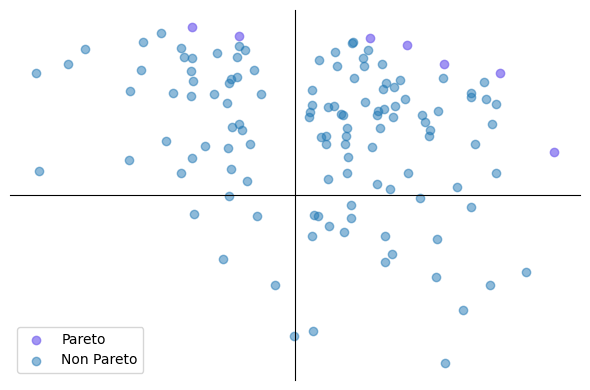

In [3]:
dataset_name = "DiskBrake"
dataset = get_dataset_instance(dataset_name)
pareto_front = botorch.utils.multi_objective.pareto.is_non_dominated(torch.tensor(dataset.out_data))
fig_pareto = plot_pareto_front(dataset.out_data, pareto_indices=pareto_front)

As you can see, there are multiple points that can not be compared with each other in our Pareto front.

In most problems that has multiple objectives, similar to our case, there are several points constituting the Pareto front. These are selected according to not being `dominated` by any other point in any of the objectives. While the selection we visualized is a valid selection, it reflects only a specific domination definition that we are all familiar with, specifically the $\leq$ ordering. We'll call this the componentwise order for obvious reasons. Let's examine this componentwise order and its domination relation with a generalized framework, *i.e.*, cones, by observing the following: a point $x$ belongs to the Pareto front if no other point is inside.

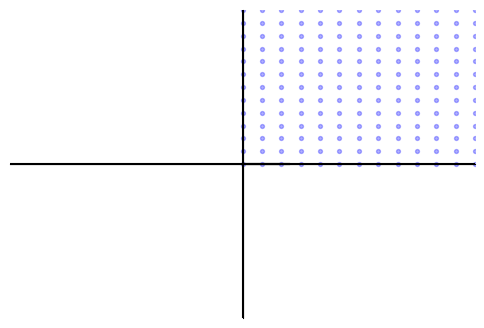

In [5]:
from vopy.order import ComponentwiseOrder

componentwise_2d_order = ComponentwiseOrder(dim=2)
_ = componentwise_2d_order.ordering_cone.plot()